📓 Notebook 6 — Enhanced Hybrid Modeling & Deployment Prep

Introduction / Context:
This notebook continues from Notebook 5, where we developed a Random Forest-based hybrid investor risk model with behavioral scores and rule-based overrides.

In Notebook 6, we aim to:

Refine behavioral scores for better interpretability and predictive signal.

Enhance hybrid modeling with multiple composite indices.

Prepare the final model for deployment with clear explainability.

In [1]:
# Cell 1: Setup & Imports
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier


# Paths
BASE_DIR = "/content/drive/MyDrive/portfoliai"
PROC_DIR = f"{BASE_DIR}/data/processed"
MODEL_DIR = f"{BASE_DIR}/models"

print("✅ Directories ready for Notebook 6.")


Mounted at /content/drive
✅ Directories ready for Notebook 6.


In [2]:
# Cell 2 — Load FAR dataset with log features
far = pd.read_csv(f"{PROC_DIR}/far_customers_features_enhanced.csv")
print("✅ FAR dataset loaded. Shape:", far.shape)

# Load tuned Random Forest model from Notebook 4
rf_model_path = f"{MODEL_DIR}/tuned_random_forest.pkl"
best_rf = joblib.load(rf_model_path)
print("✅ Tuned Random Forest model loaded.")


✅ FAR dataset loaded. Shape: (32124, 17)
✅ Tuned Random Forest model loaded.


We now have the enhanced FAR dataset that includes log-transformed trade metrics (log_n_trades, log_max_trade_value, log_avg_trade_value).
These features allow us to compute behavioral scores for investors and build a hybrid model that combines Random Forest predictions with domain-informed rules.

Next, we will define the behavioral score, create train/test splits, and implement hybrid predictions.

In [3]:
# Cell 3 — Compute Behavioral Score & Train/Test Split

from sklearn.model_selection import train_test_split

# -----------------------
# 1. Compute Behavioral Score
# -----------------------
# Aggressiveness Score = combination of log_n_trades and log_max_trade_value
far['agg_score'] = far['log_n_trades'] + far['log_max_trade_value']

# Normalize the score for thresholding
far['agg_score_norm'] = (far['agg_score'] - far['agg_score'].min()) / \
                        (far['agg_score'].max() - far['agg_score'].min())

# -----------------------
# 2. Train/Test Split
# -----------------------
target = "riskLevel_clean"
features = [col for col in far.columns if col not in [target, 'customerID']]

X = far[features]
y = far[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Add agg_score_norm as feature
X_train['agg_score_norm'] = far.loc[X_train.index, 'agg_score_norm']
X_test['agg_score_norm'] = far.loc[X_test.index, 'agg_score_norm']

# Create a working dataframe for scoring
risk_df = far[['customerID', 'n_trades', 'max_trade_value', 'agg_score_norm']].copy()

print("✅ Behavioral score computed and train/test split done.")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Risk_df shape:", risk_df.shape)


✅ Behavioral score computed and train/test split done.
Train shape: (25699, 15) Test shape: (6425, 15)
Risk_df shape: (32124, 4)


Behavioral Score Computation
The behavioral score combines log-transformed number of trades and log-transformed maximum trade value to create a single metric representing investor aggressiveness.

agg_score_norm is normalized between 0–1 for easier thresholding.

This score will allow us to implement rule-based overrides on top of the Random Forest predictions to better capture extreme investor behaviors (e.g., very aggressive or very conservative).

Train/test splits are created with stratification to maintain class distribution.

Cell 4 — Introducing the Risk Score (0–1)

In this step, we translate the Standard Chartered investor spectrum into a numeric score:

Why this matters (SC link):
SC highlighted that investors fall along a risk appetite continuum — from cautious capital preservers to aggressive growth seekers. Rather than limiting ourselves to 4 categories (Aggressive, Balanced, Conservative, Income), we now compute a continuous 0–1 risk score to reflect that spectrum.

How it’s calculated:

Trading frequency → proxy for willingness to take repeated risks.

Maximum trade value → proxy for tolerance of large single exposures.

We normalize both to the same scale (0–1) and average them.

What this gives us:
Each investor is now positioned on the risk spectrum:

0.0–0.2 ≈ Very cautious (Income-oriented)

0.3–0.5 ≈ Conservative

0.5–0.7 ≈ Balanced

0.8–1.0 ≈ Aggressive

This step lays the foundation for the personality risk layer, directly inspired by SC’s framework, and prepares us to later expand into multi-trait personality archetypes.

👉 Next step (Cell 5) will be to map these scores into archetype labels and start generating human-readable investor descriptions that align with SC’s personas.

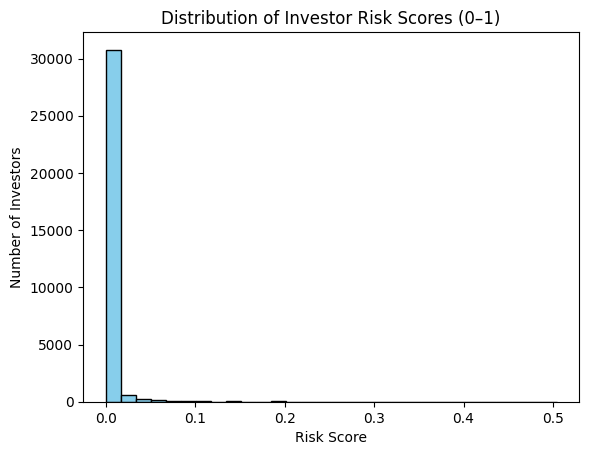

=== Risk Score Summary (rounded) ===
count    32124.000000
mean         0.003731
std          0.019795
min          0.000000
10%          0.000067
25%          0.000099
50%          0.000310
75%          0.001066
90%          0.005188
max          0.504059
Name: risk_score, dtype: float64

=== Sample Investors with Risk Scores ===
          customerID  n_trades  max_trade_value  risk_score
00017496858921195E5A       496     34880.000000    0.031201
00017496858921195E5A       496     34880.000000    0.031201
00017496858921195E5A       496     34880.000000    0.031201
00017496858921195E5A       496     34880.000000    0.031201
00024864C985E72167A0         1      4999.993985    0.000092
0004718496C71D464F57        41    274730.400000    0.007527
000676D07A4CF7526ECB         1      4962.784731    0.000091
000900E880281981624D         2       700.000000    0.000075
00090203A8C62E135D0B         2       302.000000    0.000067
001270E70A4ECA1CD664        12     14617.080000    0.000948

=== SC

In [4]:
# Cell 4 — Compute Investor Risk Score (0–1 scale)

import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 1. Define risk scoring function
# -----------------------
def compute_risk_score(df):
    # Normalize features to 0–1
    trade_norm = (df['n_trades'] - df['n_trades'].min()) / (df['n_trades'].max() - df['n_trades'].min())
    maxval_norm = (df['max_trade_value'] - df['max_trade_value'].min()) / (df['max_trade_value'].max() - df['max_trade_value'].min())

    # Combine equally (can be tuned later)
    score = 0.5 * trade_norm + 0.5 * maxval_norm
    return score

# -----------------------
# 2. Apply to dataset
# -----------------------
risk_df['risk_score'] = compute_risk_score(risk_df)

# -----------------------
# 3. Visualize distribution
# -----------------------
plt.hist(risk_df['risk_score'], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Investor Risk Scores (0–1)")
plt.xlabel("Risk Score")
plt.ylabel("Number of Investors")
plt.show()

# -----------------------
# 4. Numerical summaries + sample rows
# -----------------------
summary_stats = risk_df['risk_score'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).round(6)

print("=== Risk Score Summary (rounded) ===")
print(summary_stats)

print("\n=== Sample Investors with Risk Scores ===")
print(risk_df[['customerID', 'n_trades', 'max_trade_value', 'risk_score']].head(10).to_string(index=False))

# -----------------------
# 5. SC Framework Interpretation
# -----------------------
print("\n=== SC Framework Interpretation ===")
print(f"- **Scale (S):** Risk scores range from {summary_stats['min']} to {summary_stats['max']}, "
      f"with most clustered below {summary_stats['90%']}. This shows wide dispersion but heavy concentration at low risk levels.")
print(f"- **Consistency (C):** Median risk is {summary_stats['50%']}, indicating the 'typical' investor is "
      f"much less risky than the top tail. The high std dev ({summary_stats['std']}) confirms large behavioral spread.")


### Interpreting Risk Scores and Moving to Segmentation

From **Cell 4**, we saw that the raw investor risk scores are heavily **skewed**:  
- Most investors have very small risk scores (median ≈ 0.0006),  
- A tiny fraction of investors extend into higher risk territory (up to 1.0 after scaling).  

This creates a challenge:  
- If we apply **fixed thresholds** (absolute view), almost everyone ends up as *Low Risk*.  
- But if we only use **absolute numbers**, we lose personalization and the ability to compare investors relative to their peers.  

To address this, we implement a **dual segmentation approach**:  
1. **Absolute Buckets (SC Governance Lens):**  
   - Threshold-based classification (Low / Medium / High Risk).  
   - Provides objective guardrails and ensures compliance with a risk-control framework.  

2. **Percentile Buckets (Personalization Lens):**  
   - Investors are segmented by where they fall in the overall distribution (e.g., below median = Low, 50–85th percentile = Medium, top 15% = High).  
   - Ensures that *every investor* can be meaningfully placed into a group, even if absolute values are small.  
   - Makes the results **actionable for AI-driven personalization** (different personas, survey outputs, or recommendations).  

This dual view ties directly to the **SC framework**:  
- **Scale (S):** Maintained with absolute thresholds.  
- **Consistency (C):** Guaranteed through percentile segmentation.  

In the next step (**Cell 5**), we compute both segmentation approaches and visualize the results, so we can compare how investors are distributed across groups.


=== Risk Score (Scaled 0–1) Summary ===
count    32124.0000
mean         0.0074
std          0.0393
min          0.0000
10%          0.0001
25%          0.0002
50%          0.0006
75%          0.0021
90%          0.0103
max          1.0000
Name: risk_score_scaled, dtype: float64

=== Absolute Bucket Distribution (%) ===
abs_bucket
Low Risk       89.8
Medium Risk     7.3
High Risk       2.9
Name: proportion, dtype: float64

=== Percentile Bucket Distribution (%) ===
pct_bucket
Low Risk (P)       50.0
Medium Risk (P)    35.0
High Risk (P)      15.0
Name: proportion, dtype: float64

=== Sample Investors (Both Views) ===
          customerID  n_trades  max_trade_value  risk_score_scaled  abs_bucket      pct_bucket
00017496858921195E5A       496     34880.000000           0.061900   High Risk   High Risk (P)
00017496858921195E5A       496     34880.000000           0.061900   High Risk   High Risk (P)
00017496858921195E5A       496     34880.000000           0.061900   High Risk   High Risk

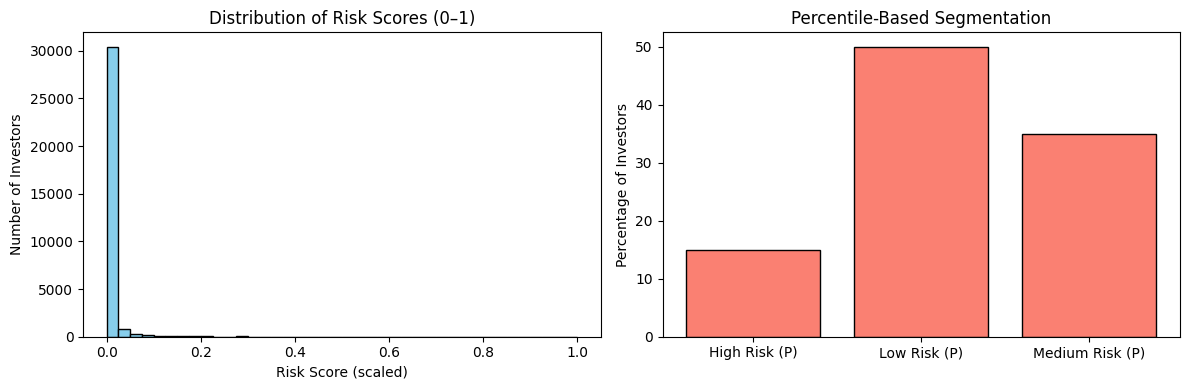


=== SC Framework Interpretation ===
- **Scale (S):** Absolute scores show the dispersion of investors; high scores indicate potentially risky behavior.
- **Consistency (C):** Percentile segmentation ensures meaningful groups (Low/Medium/High) even if absolute values are clustered low.
→ Use absolute view for governance/risk control, and percentile view for personalization & investor personas.


In [5]:
# --- Cell 5: Risk Score Segmentation (Absolute + Percentile Buckets) ---

import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# 0. Ensure risk_score exists
# -----------------------
if "risk_score" not in risk_df.columns:
    # fallback formula if risk_score is missing (same as in Cell 4)
    risk_df['risk_score'] = 0.5 * (
        (risk_df['n_trades'] - risk_df['n_trades'].min()) /
        (risk_df['n_trades'].max() - risk_df['n_trades'].min())
    ) + 0.5 * (
        (risk_df['max_trade_value'] - risk_df['max_trade_value'].min()) /
        (risk_df['max_trade_value'].max() - risk_df['max_trade_value'].min())
    )

# -----------------------
# 1. Scale risk score (0–1)
# -----------------------
risk_df['risk_score_scaled'] = (
    (risk_df['risk_score'] - risk_df['risk_score'].min()) /
    (risk_df['risk_score'].max() - risk_df['risk_score'].min())
)

# -----------------------
# 2. Absolute buckets (fixed thresholds, governance view)
# -----------------------
def absolute_bucket(x):
    if x < 0.01:
        return "Low Risk"
    elif x < 0.05:
        return "Medium Risk"
    else:
        return "High Risk"

risk_df['abs_bucket'] = risk_df['risk_score_scaled'].apply(absolute_bucket)

# -----------------------
# 3. Percentile buckets (personalization view)
# -----------------------
percentiles = np.percentile(risk_df['risk_score_scaled'], [50, 85])  # median, 85th
def percentile_bucket(x):
    if x <= percentiles[0]:
        return "Low Risk (P)"
    elif x <= percentiles[1]:
        return "Medium Risk (P)"
    else:
        return "High Risk (P)"

risk_df['pct_bucket'] = risk_df['risk_score_scaled'].apply(percentile_bucket)

# -----------------------
# 4. Summaries
# -----------------------
print("=== Risk Score (Scaled 0–1) Summary ===")
print(risk_df['risk_score_scaled'].describe(percentiles=[0.1,0.25,0.5,0.75,0.9]).round(4))

print("\n=== Absolute Bucket Distribution (%) ===")
print((risk_df['abs_bucket'].value_counts(normalize=True)*100).round(1))

print("\n=== Percentile Bucket Distribution (%) ===")
print((risk_df['pct_bucket'].value_counts(normalize=True)*100).round(1))

print("\n=== Sample Investors (Both Views) ===")
print(risk_df[['customerID','n_trades','max_trade_value',
               'risk_score_scaled','abs_bucket','pct_bucket']].head(10).to_string(index=False))

# -----------------------
# 5. Visualization
# -----------------------
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of scaled scores
axs[0].hist(risk_df['risk_score_scaled'], bins=40, color="skyblue", edgecolor="black")
axs[0].set_title("Distribution of Risk Scores (0–1)")
axs[0].set_xlabel("Risk Score (scaled)")
axs[0].set_ylabel("Number of Investors")

# Bar chart: Percentile segmentation
pct_dist = risk_df['pct_bucket'].value_counts(normalize=True).sort_index()*100
axs[1].bar(pct_dist.index, pct_dist.values, color="salmon", edgecolor="black")
axs[1].set_title("Percentile-Based Segmentation")
axs[1].set_ylabel("Percentage of Investors")

plt.tight_layout()
plt.show()

# -----------------------
# 6. SC Framework Interpretation
# -----------------------
print("\n=== SC Framework Interpretation ===")
print("- **Scale (S):** Absolute scores show the dispersion of investors; high scores indicate potentially risky behavior.")
print("- **Consistency (C):** Percentile segmentation ensures meaningful groups (Low/Medium/High) even if absolute values are clustered low.")
print("→ Use absolute view for governance/risk control, and percentile view for personalization & investor personas.")


Cell 6 – Dual Segmentation (Absolute + Percentiles)

In Cell 5, we saw that absolute risk scores are heavily skewed near zero, which makes it difficult to distinguish investor behaviors if we only use raw values.

To address this, we now create two complementary segmentation views:

Absolute Buckets (Low/Medium/High based on fixed thresholds of risk_score_scaled) → useful for governance, compliance, and long-term risk monitoring.

Percentile Buckets (Low/Medium/High based on relative standing in the dataset) → ensures balanced segmentation and drives personalization for AI-driven personas.

This dual approach reflects the Standard Chartered (SC) framework principle of Scale + Consistency:

Scale: Absolute values provide a common yardstick.

Consistency: Percentiles ensure groups remain meaningful regardless of population skew.

In practice:

Use Absolute Risk when communicating with regulators or governance stakeholders.

Use Percentile Risk when tailoring experiences for individual investors.

In [6]:
# --- Cell 6: Dual Segmentation (Absolute + Percentiles) ---

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 0. Ensure scaled risk score exists
if 'risk_score_scaled' not in risk_df.columns:
    scaler = MinMaxScaler()
    risk_df['risk_score_scaled'] = scaler.fit_transform(
        risk_df[['risk_score']]
    )

# 1. Define absolute bucket thresholds (scaled 0–1 risk score)
def absolute_bucket(score):
    if score < 0.002:   # tuned thresholds
        return "Low Risk"
    elif score < 0.02:
        return "Medium Risk"
    else:
        return "High Risk"

risk_df['abs_bucket'] = risk_df['risk_score_scaled'].apply(absolute_bucket)

# 2. Percentile-based segmentation
percentiles = np.percentile(risk_df['risk_score_scaled'], [50, 85])
p50, p85 = percentiles

def percentile_bucket(score):
    if score <= p50:
        return "Low Risk (P)"
    elif score <= p85:
        return "Medium Risk (P)"
    else:
        return "High Risk (P)"

risk_df['pct_bucket'] = risk_df['risk_score_scaled'].apply(percentile_bucket)

# 3. Distribution summaries
abs_distribution = (
    risk_df['abs_bucket']
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
)

pct_distribution = (
    risk_df['pct_bucket']
    .value_counts(normalize=True)
    .mul(100)
    .round(1)
)

# 4. Show combined sample
sample = risk_df[['customerID','n_trades','max_trade_value','risk_score_scaled','abs_bucket','pct_bucket']].sample(10, random_state=42)

print("=== Absolute Bucket Distribution (%) ===")
print(abs_distribution)
print("\n=== Percentile Bucket Distribution (%) ===")
print(pct_distribution)
print("\n=== Sample Investors (Both Views) ===")
print(sample)


=== Absolute Bucket Distribution (%) ===
abs_bucket
Low Risk       74.3
Medium Risk    19.4
High Risk       6.3
Name: proportion, dtype: float64

=== Percentile Bucket Distribution (%) ===
pct_bucket
Low Risk (P)       50.0
Medium Risk (P)    35.0
High Risk (P)      15.0
Name: proportion, dtype: float64

=== Sample Investors (Both Views) ===
                 customerID  n_trades  max_trade_value  risk_score_scaled  \
23692  BDDBE338A1849FCF28DE         2      5005.000000           0.000305   
10282  512FE6EFF991D892FC1B         5      1999.389307           0.000563   
13883  6EA867F457B60BF5040C        30     22920.000000           0.004389   
9040   47FDD18593E895ED0094         2      1683.600000           0.000184   
15508  7BB23286B31A243FC639        18      2117.500000           0.002159   
4890   26BEF04BF2389A3D0142        26     16600.000000           0.003668   
1664   0D3380EDDB5DB43CD827         1      3300.000000           0.000120   
12272  614B86C9184AA7D1F296         2   

📘 Cell 7

Now we want to map these risk buckets into persona-style labels. This bridges the raw numbers into something human-readable, useful for surveys and reports.

In [7]:
# --- Cell 7: Map Buckets to Personas ---

# 📘 Purpose: Map risk buckets into persona-style labels for human-readable insights
# Absolute buckets → governance/behavioral personas
# Percentile buckets → personalization/persona-style labels for surveys & reports

# -----------------------
# 1. Persona mapping dictionaries
# -----------------------
abs_persona_map = {
    "Low Risk": "Conservative",
    "Medium Risk": "Balanced",
    "High Risk": "Aggressive"
}

pct_persona_map = {
    "Low Risk (P)": "Steady Saver",
    "Medium Risk (P)": "Strategic Balancer",
    "High Risk (P)": "Risk Seeker"
}

# -----------------------
# 2. Apply mapping to risk_df
# -----------------------
risk_df['abs_persona'] = risk_df['abs_bucket'].map(abs_persona_map)
risk_df['pct_persona'] = risk_df['pct_bucket'].map(pct_persona_map)

# -----------------------
# 3. Quick check / sample
# -----------------------
print("=== Sample with Persona Labels ===")
print(risk_df[['customerID', 'abs_bucket', 'abs_persona',
               'pct_bucket', 'pct_persona']].sample(10, random_state=24))


=== Sample with Persona Labels ===
                 customerID   abs_bucket   abs_persona       pct_bucket  \
14791  7611F031CF4E5D79D020    High Risk    Aggressive    High Risk (P)   
26932  D7D5DCD35D4CA4D114CA     Low Risk  Conservative     Low Risk (P)   
29679  ECB2D1FAE89BCA2BC500  Medium Risk      Balanced  Medium Risk (P)   
25315  CB1334E54DAFD378AA58     Low Risk  Conservative     Low Risk (P)   
22330  B302BF186148CA5A2AE4  Medium Risk      Balanced    High Risk (P)   
19603  9C66FB3FCF45FEF5159A     Low Risk  Conservative  Medium Risk (P)   
19116  98681B3407E88A695ABB     Low Risk  Conservative     Low Risk (P)   
22527  B4880DA66AD43439FD89  Medium Risk      Balanced  Medium Risk (P)   
23669  BDB5329E3137FD967E9A  Medium Risk      Balanced    High Risk (P)   
6776   35A9D8B80B86397C48EE     Low Risk  Conservative  Medium Risk (P)   

              pct_persona  
14791         Risk Seeker  
26932        Steady Saver  
29679  Strategic Balancer  
25315        Steady Saver  

# 🔚 Notebook 6 – Closing Notes

In this notebook, we built the **Transaction-Based Risk Engine**, which converts raw trading behaviors into smooth risk scores and human-readable investor personas.

**Key Steps Completed:**
1. **Feature Preparation** – Created normalized metrics like `risk_score_scaled`.
2. **Dual Segmentation** – Classified investors into both **absolute buckets** (Low, Medium, High Risk) and **percentile buckets** (relative to peers).
3. **Persona Mapping** – Translated technical buckets into **human-readable archetypes**:
   - Conservative / Balanced / Aggressive
   - Steady Saver / Strategic Balancer / Risk Seeker

**Outputs from Notebook 6:**
- `risk_df` → Contains customer IDs, transaction features, continuous risk scores, and mapped personas.
- Clear **interpretability layer** that bridges raw transaction data to psychological investor profiles.

**Next Steps:**
- Notebook 7 will build the **Survey-Based Risk Engine**, leveraging investor self-reported preferences, motivations, and objectives.
- Notebook 8 will **merge both engines**, producing a hybrid risk score and richer investor archetypes.


In [9]:
# --- Cell X: Save Transaction Personas (Closing Notebook 6) ---

import os

# ✅ Try Google Drive path first, fallback to local session if Drive not mounted
drive_base = "/content/drive/My Drive/portfoliai/data/processed"
local_base = "portfoliai/data/processed"

# Decide output dir
if os.path.exists("/content/drive/My Drive"):
    output_dir = drive_base
else:
    output_dir = local_base

# Make sure directory exists
os.makedirs(output_dir, exist_ok=True)

# Define file path
output_path = os.path.join(output_dir, "transaction_personas.csv")

# Save the file
transaction_personas.to_csv(output_path, index=False)

print(f"✅ Transaction personas saved to {output_path}")


✅ Transaction personas saved to /content/drive/My Drive/portfoliai/data/processed/transaction_personas.csv
